<a href="https://colab.research.google.com/github/ahalyasanjiv/ChildhoodLeadExposure/blob/master/Linear_Regression_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear Regression Model 

In our data exploration, we have investigated the link between lead exposure and the demographic makeup, poverty level, and housing related data for a neighborhood.

Now we want to use what we learned from that to create a model that will allow us to predict the level of risk a neighborhood has for lead exposure.

In this notebook, we will be creating a **linear regression model**, which as we defined in class, is a method to model the relationship between a set of independent variables 𝑋 (also knowns as explanatory variables, features, predictors) and a dependent variable 𝑌 .

To do this, we will use numpy, statsmodels, and scikit-learn.

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

%matplotlib inline

To summarize:

We found that in the NYS data (by zip code), there was a link found between the demographic percentages and the lead levels.

Features with positive correlations found between with incidences of elevated lead found in childhood blood:
- Percentage of blacks/African-Americans (0.28)
- Percentage of people who belong to two or more races (0.19)
- Percentage of people of Hispanic/Latino origin (0.12)
- Percentage of people who live below the poverty line (0.10).

Features with negative correlation found between incidences of elevated lead found in childhood:
- Percentage of white people living in a neighborhood (- 0.23). 

In the nation-wide data collected for 26 states (by county), the percentage of hispanics living in the county had the most significant correlation with the percentage of children with levels higher than 5 ug/dl (0.39!). Correlation with the percentage of whites living in the county had a negative correlation of -0.19, which is relatively close to what was found in the NYS data.

The correlation with income and poverty was at around -0.11 for income and 0.12 for poverty.

When looking at housing data for the United States for the percentage of houses built before a certain date, we found a slightly positive correlation.



To build the model, we will use NY State data by zip code. Ideally, we would like to use census tract data to allow for greater granularity, but we have only found lead data by zip code. The nation-wide data we found was by county, which although was useful for the sake of data exploration, it is not nearly as granular as we would like the model to be. 

In [0]:
# Read the dataset that was created from merged/cleaned lead level and demographics data for NYS by zip code (Refer to Investigating_Correlation_Between_Lead_Exposure_and_Demographics.ipynb)
lead_df = pd.read_csv('https://raw.githubusercontent.com/ahalyasanjiv/ChildhoodLeadExposure/master/data/NYS_Lead_Levels_and_Demographics.csv')
# Read the cleaned housing data for NYS by zip code
housing_df = pd.read_csv('https://raw.githubusercontent.com/ahalyasanjiv/ChildhoodLeadExposure/master/data/Housing_Units_Built_Pecentage_by_Year.csv')

Let's join the datasets on the zip code column.

In [3]:
df = lead_df.set_index('Zip Code').join(housing_df.set_index('Zip'), how='inner')
df.corr()['Percent Elevated Lead Cases'][1:]

One race - White                                                                            -0.228129
One race - Black or African American                                                         0.282719
One race - American Indian and Alaska Native                                                -0.005676
One race - Asian                                                                             0.032635
One race - Native Hawaiian and Other Pacific Islander                                       -0.022942
One race - Some other race                                                                   0.094792
Two or more races                                                                            0.188702
Hispanic or Latino origin (of any race)                                                      0.126239
White alone, not Hispanic or Latino                                                         -0.211089
Median Income                                                                     

We some contenders for predictors of lead exposure:
- Percentage of population that is black or African American (+ correlation)
- Percentage of population that is Hispanic or Latino origin (+ corrrelation)
- Percentage of population that is white (- correlation)
- Percentage of housing units built before 1950 (+ correlation)
- Percentage of population living below the poverty line (+ correlation)

## Single Variable Linear Regression Model
First, let's try a simple model using one feature as the predictor - percentage of blacks/African-Americans, since it has the highest correlation coefficient with 'Percent Elevated Lead Cases'.

We will use numpy's polyfit function to accomplish this.

In [4]:
# Get slope and intercept for the model
beta, alpha = np.polyfit(df['One race - Black or African American'], df['Percent Elevated Lead Cases'], 1)
print('beta: %0.3f, alpha: %0.3f.' % (beta, alpha))


beta: 0.105, alpha: 1.079.


Let's see how well this line fits the data.

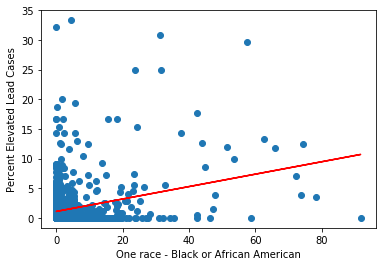

In [5]:
y = df['One race - Black or African American']*beta + alpha

_ = plt.scatter(df['One race - Black or African American'], df['Percent Elevated Lead Cases'])
_ = plt.plot(df['One race - Black or African American'], y, color='r')
_ = plt.xlabel('One race - Black or African American')
_ = plt.ylabel('Percent Elevated Lead Cases')

plt.show()

As we can see here, the data does have a number of outliers. Of course, there will be cases of elevated incidences of lead in zip codes where there is little to no black/African-American population. This variable has a correlation with the To get a better idea of the error, we will use the residual difference between the predicted percentage of elevated lead cases and the actual percentage.

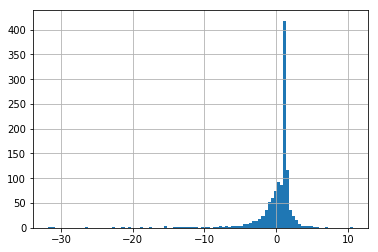

In [6]:
df['predicted_elevated_lead_percentage'] = df['One race - Black or African American'] * beta + alpha
df['residual_elevated_lead_percentage'] = df['predicted_elevated_lead_percentage'] - df['Percent Elevated Lead Cases']
df['residual_elevated_lead_percentage'].hist(bins=100)

The residual percentage clustered mostly around about 2%. 

## Using statsmodel For Multiple Linear Regression


In [7]:
df = sm.add_constant(df)

# First let's try single variable linear regression with the previous variable we used
est = sm.OLS(df['Percent Elevated Lead Cases'], 
             df[['const', 'One race - Black or African American']]
            ).fit()

print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:     Percent Elevated Lead Cases   R-squared:                       0.080
Model:                                     OLS   Adj. R-squared:                  0.079
Method:                          Least Squares   F-statistic:                     102.8
Date:                         Wed, 15 May 2019   Prob (F-statistic):           3.24e-23
Time:                                 02:35:40   Log-Likelihood:                -3047.3
No. Observations:                         1185   AIC:                             6099.
Df Residuals:                             1183   BIC:                             6109.
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [8]:
# Adding other variables to our model
est = sm.OLS(df['Percent Elevated Lead Cases'], 
             df[['const', 'One race - Black or African American',
                 '% of housing units built before 1950',
                'Hispanic or Latino origin (of any race)',
                'One race - White',
                 'Two or more races',
                 'Population for whom poverty status is determined - Below 100 percent of the poverty level',
                'Total Housing Units']]
            ).fit()

print(est.summary())

                                 OLS Regression Results                                
Dep. Variable:     Percent Elevated Lead Cases   R-squared:                       0.146
Model:                                     OLS   Adj. R-squared:                  0.141
Method:                          Least Squares   F-statistic:                     28.84
Date:                         Wed, 15 May 2019   Prob (F-statistic):           7.39e-37
Time:                                 02:35:41   Log-Likelihood:                -3002.9
No. Observations:                         1185   AIC:                             6022.
Df Residuals:                             1177   BIC:                             6062.
Df Model:                                    7                                         
Covariance Type:                     nonrobust                                         
                                                                                                coef    std err         

Let us examine the histogram of the residuals.



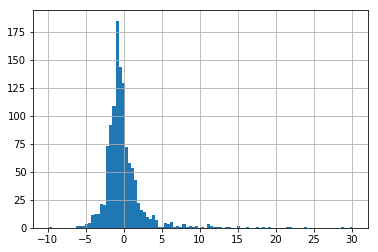

In [9]:
est.resid.hist(bins=100)

It appears this histogram is more normally distributed than the previous one. 

When deciding which predictors to keep, we should consider the p-value. Predictors with low p-values are considered likely to be significant because changes in their values are related to changes in the target variable.

In the above OLS Regression results, we see that the p-values for percentage of population that is of Hispanic or Latino origin (0.892) and % below the poverty line (0.510) are much greater than the alpha level of 0.05. We will therefore remove them from our model.

In [10]:
est = sm.OLS(df['Percent Elevated Lead Cases'], 
             df[['const', 'One race - Black or African American',
                 '% of housing units built before 1950',
                'One race - White',
                 'Two or more races',
                'Total Housing Units']]
            ).fit()
print(est.summary())


                                 OLS Regression Results                                
Dep. Variable:     Percent Elevated Lead Cases   R-squared:                       0.146
Model:                                     OLS   Adj. R-squared:                  0.142
Method:                          Least Squares   F-statistic:                     40.34
Date:                         Wed, 15 May 2019   Prob (F-statistic):           2.26e-38
Time:                                 02:35:41   Log-Likelihood:                -3003.1
No. Observations:                         1185   AIC:                             6018.
Df Residuals:                             1179   BIC:                             6049.
Df Model:                                    5                                         
Covariance Type:                     nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
---------------

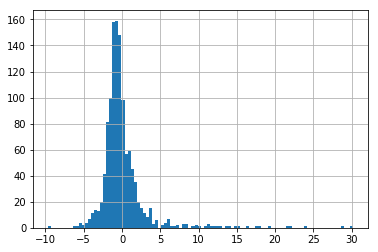

In [11]:
# Graph histogram of the residuals
est.resid.hist(bins=100)

When we look at our model's adjusted r-squared value, we notice that it is not as high as we would ideally like it to be. Lead exposure is difficult to predict because there are lots of different factors that can correlate with it, but they do not necessarily cause it. 

## Using sklearn to Create a Multiple Linear Regression Model

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [0]:
# Create the linear regressor (reg)
reg = LinearRegression()

In [0]:
# First, let's list the dependent variables we wish to use
dependent_vars = ['One race - Black or African American',
                 '% of housing units built before 1950',
                'One race - White',
                 'Two or more races',
                'Total Housing Units']
X = df[dependent_vars].values

In [0]:
y = df['Percent Elevated Lead Cases'].values

In [0]:
# Split the data 80/20 for traintest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [40]:
# Fit the model with the training data
reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [43]:
# Predict on the test data
y_pred = reg.predict(X_test)

# Print R^2 and Root Mean Squared Error
print("R^2: {}".format(reg.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
print("Root Mean Squared Error: {}".format(rmse))


R^2: 0.21560599060705832
Root Mean Squared Error: 2.424735170855593


## Using Cross-Validation

Using  cross-validation will allow us to maximize the amount of data that is used to train the model. All the data will be used to train and test through this process.

In [44]:
from sklearn.model_selection import cross_val_score

# Compute the cross-validation scores
cv_scores = cross_val_score(reg,X,y,cv=5)

# Print the cross-validation scores
print(cv_scores)

# Take the average
np.mean(cv_scores)

[ 0.11265804  0.10941944  0.00796294 -0.01337791  0.24584454]


0.09250141105376135

## Regularization
We want to regularize because it allows for a way to penalize large coefficients since they can lead to overfitting. 



In [0]:
# Import necessary modules
from sklearn.linear_model import Ridge


In [0]:

# Setup the array of alphas and lists to store scores
alpha_space = np.logspace(-4, 0, 50)
ridge_scores = []
ridge_scores_std = []


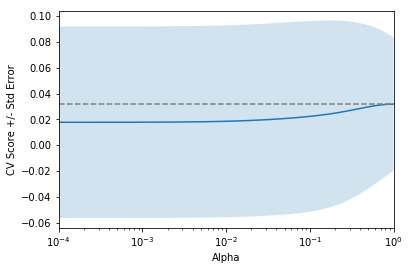

In [47]:
# Note: The following is adapted from the DataCamp Regression Chapter 

def display_plot(cv_scores, cv_scores_std):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax.plot(alpha_space, cv_scores)

    std_error = cv_scores_std / np.sqrt(10)

    ax.fill_between(alpha_space, cv_scores + std_error, cv_scores - std_error, alpha=0.2)
    ax.set_ylabel('CV Score +/- Std Error')
    ax.set_xlabel('Alpha')
    ax.axhline(np.max(cv_scores), linestyle='--', color='.5')
    ax.set_xlim([alpha_space[0], alpha_space[-1]])
    ax.set_xscale('log')
    plt.show()
    
# Create a ridge regressor: ridge
ridge = Ridge(normalize=True)

# Compute scores over range of alphas
for alpha in alpha_space:

    # Specify the alpha value to use: ridge.alpha
    ridge.alpha = alpha
    
    # Perform 10-fold CV: ridge_cv_scores
    ridge_cv_scores = cross_val_score(ridge, X, y, cv=10)
    
    # Append the mean of ridge_cv_scores to ridge_scores
    ridge_scores.append(np.mean(ridge_cv_scores))
    
    # Append the std of ridge_cv_scores to ridge_scores_std
    ridge_scores_std.append(np.std(ridge_cv_scores))

# Display the plot
display_plot(ridge_scores, ridge_scores_std)
